# Time Series Motif Discovery for User Interaction Logs

### Description

Time series data mining plays a crucial role in uncovering routines within user interaction logs. By analyzing sequences of user actions over time, data mining techniques can identify recurring patterns and behaviors. This allows us to understand how users typically navigate through a system, what actions they perform in sequence, and at what intervals. By uncovering these routines, we can gain valuable insights into user habits and preferences. This knowledge can then be used to optimize user interfaces, personalize experiences, and ultimately improve user satisfaction. For example, time series data mining might reveal a common sequence of actions users take to complete a specific task. This information could be used to streamline the process by suggesting the next step or automating repetitive actions.

### Functionallity of this Notebook

This notebook has three sections seperated into data preprocessing, Time Series Mining, and visualisation through Process Discovery.
As with any Jupyter Notebook you can run each cell. For the method to properly work you have to setup the first cell after the library import accordingly. This cell contains the settings of the discovery approach. The attributes to be set are described in more detail before the cell.

1. Section Preprocessing: In this section the necessery libraries are imported and the UI log is processed.
2. Section Time Series Mining: The algorithm discovers the motifs based on the setup parameters.
    - First, the UI log is encoded using our continuous hot encoding methodology.
    - Second, if you set the parameter for window size calculation the window size will be calculated. Otherwise the specified window size is used.
    - Third, the motif discovery is performed for the number of motifs you specified in the settings. 
3. The discovered motifs in the UI log are processed in a process discovery algorithm. The resulting directly follows graph is presented.

#### PreProcessing

In [1]:
import pandas as pd
import numpy as np
import stumpy
from stumpy import config

import util.util

import matplotlib.pyplot as plt
import pm4py
import webbrowser
import os

#### Settings

UiLogPath >>> String: Folder path in which the UI log is stored.

UiLogFilename >>> String: Name of the UiLog.

UiLogContextColumns >>> List: List of all names that should be considered as discovery dimensions. E.g., in Agostinelli et al.s logs we have considered the columns "case:concept:name", "application", and "concept:name". In the Activity Window Tracking by Beerepoot et al. we considered the columns "Title" and "App".

TimeStampColumn >>> Str: Name of the column containing the time stamp in the UI log.

WindowSizeCalculation >>> True or False: If True the window size will be calculated using the calculation method described in our paper based on the method in 

BreakTime >>> Int: Integer representing the number of seconds that are considered as a significant user break, e.g., lunch break or break between two UI log recording sessions. Set this parameter to exclude these breaks from the window size calculation. We recommend 300 seconds, i.e., 5 minutes, as an initial start value for breaks.

ManualWindowSize >>> int: Set an integer value if the previous parameter is set to False. Otherwise a default value of 1% of the log length is choosen.

NumberOfMotifsToDiscover >>> int: Integer value ranging from 2 to infinity (possibly) as input for the discovery of multiple occurances of the motif. The result will contain the number of motifs with the closest matching distance measure independent of actual motif similiarity.

The settings are initially set for the UI log from our running example.

In [2]:
# ---- Select One of the following or set own parameters to own UI log ----
# SmartRPA
UiLogPath = "logs/smartRPA/percentageComparison/"
UiLogFilename = "LenLog_1_10_1_60_20_10_12000.csv"
encoding_method = "utf-8"
seperator = ","
awt_data = False
ContextColumns = ["category","application","concept:name"] # SmartRPA / Running Example Data
timeStampColumn = "time:timestamp"

# ---- Running Example SmartRPA ----
# UiLogPath = "logs/Banking/"
# UiLogFilename = "RunningExampleSmartRPA.csv"
# encoding_method = "utf-8"
# seperator = ","
# awt_data = False
# ContextColumns = ["category","application","concept:name"] # SmartRPA / Running Example Data
# timeStampColumn = "time:timestamp"

# ---- Running Example Tockler ----
# UiLogPath = "logs/Banking/"
# UiLogFilename = "RunningExampleTockler.csv"
# encoding_method  = "latin-1"
# seperator = ","
# awt_data = True
# ContextColumns = ["App","Title"] # AWT Data
# timeStampColumn = "Begin"

# ---- AWT Data ----
# UiLogPath = "logs/AWT/"
# UiLogFilename = "AWT_data_Iris_March_2023_labelled_step5.csv"
# encoding_method  = "latin-1"
# seperator = ";"
# awt_data = True
# ContextColumns = ["App","Title"] # AWT Data
# timeStampColumn = "Begin"

# ---- Configure your settings according to the approach ---- 
WindowSizeCalculation = False
BreakTime = 300
ManualWindowSize = 25
NumberOfMotifsToDiscover = 10

The window size was manually set and is 25.
The motif discovery is complete. The following indexes are the starting points of the discovered motifs: [  462   755  4510  4847  5474  6973  7469  8768  9599 11260]


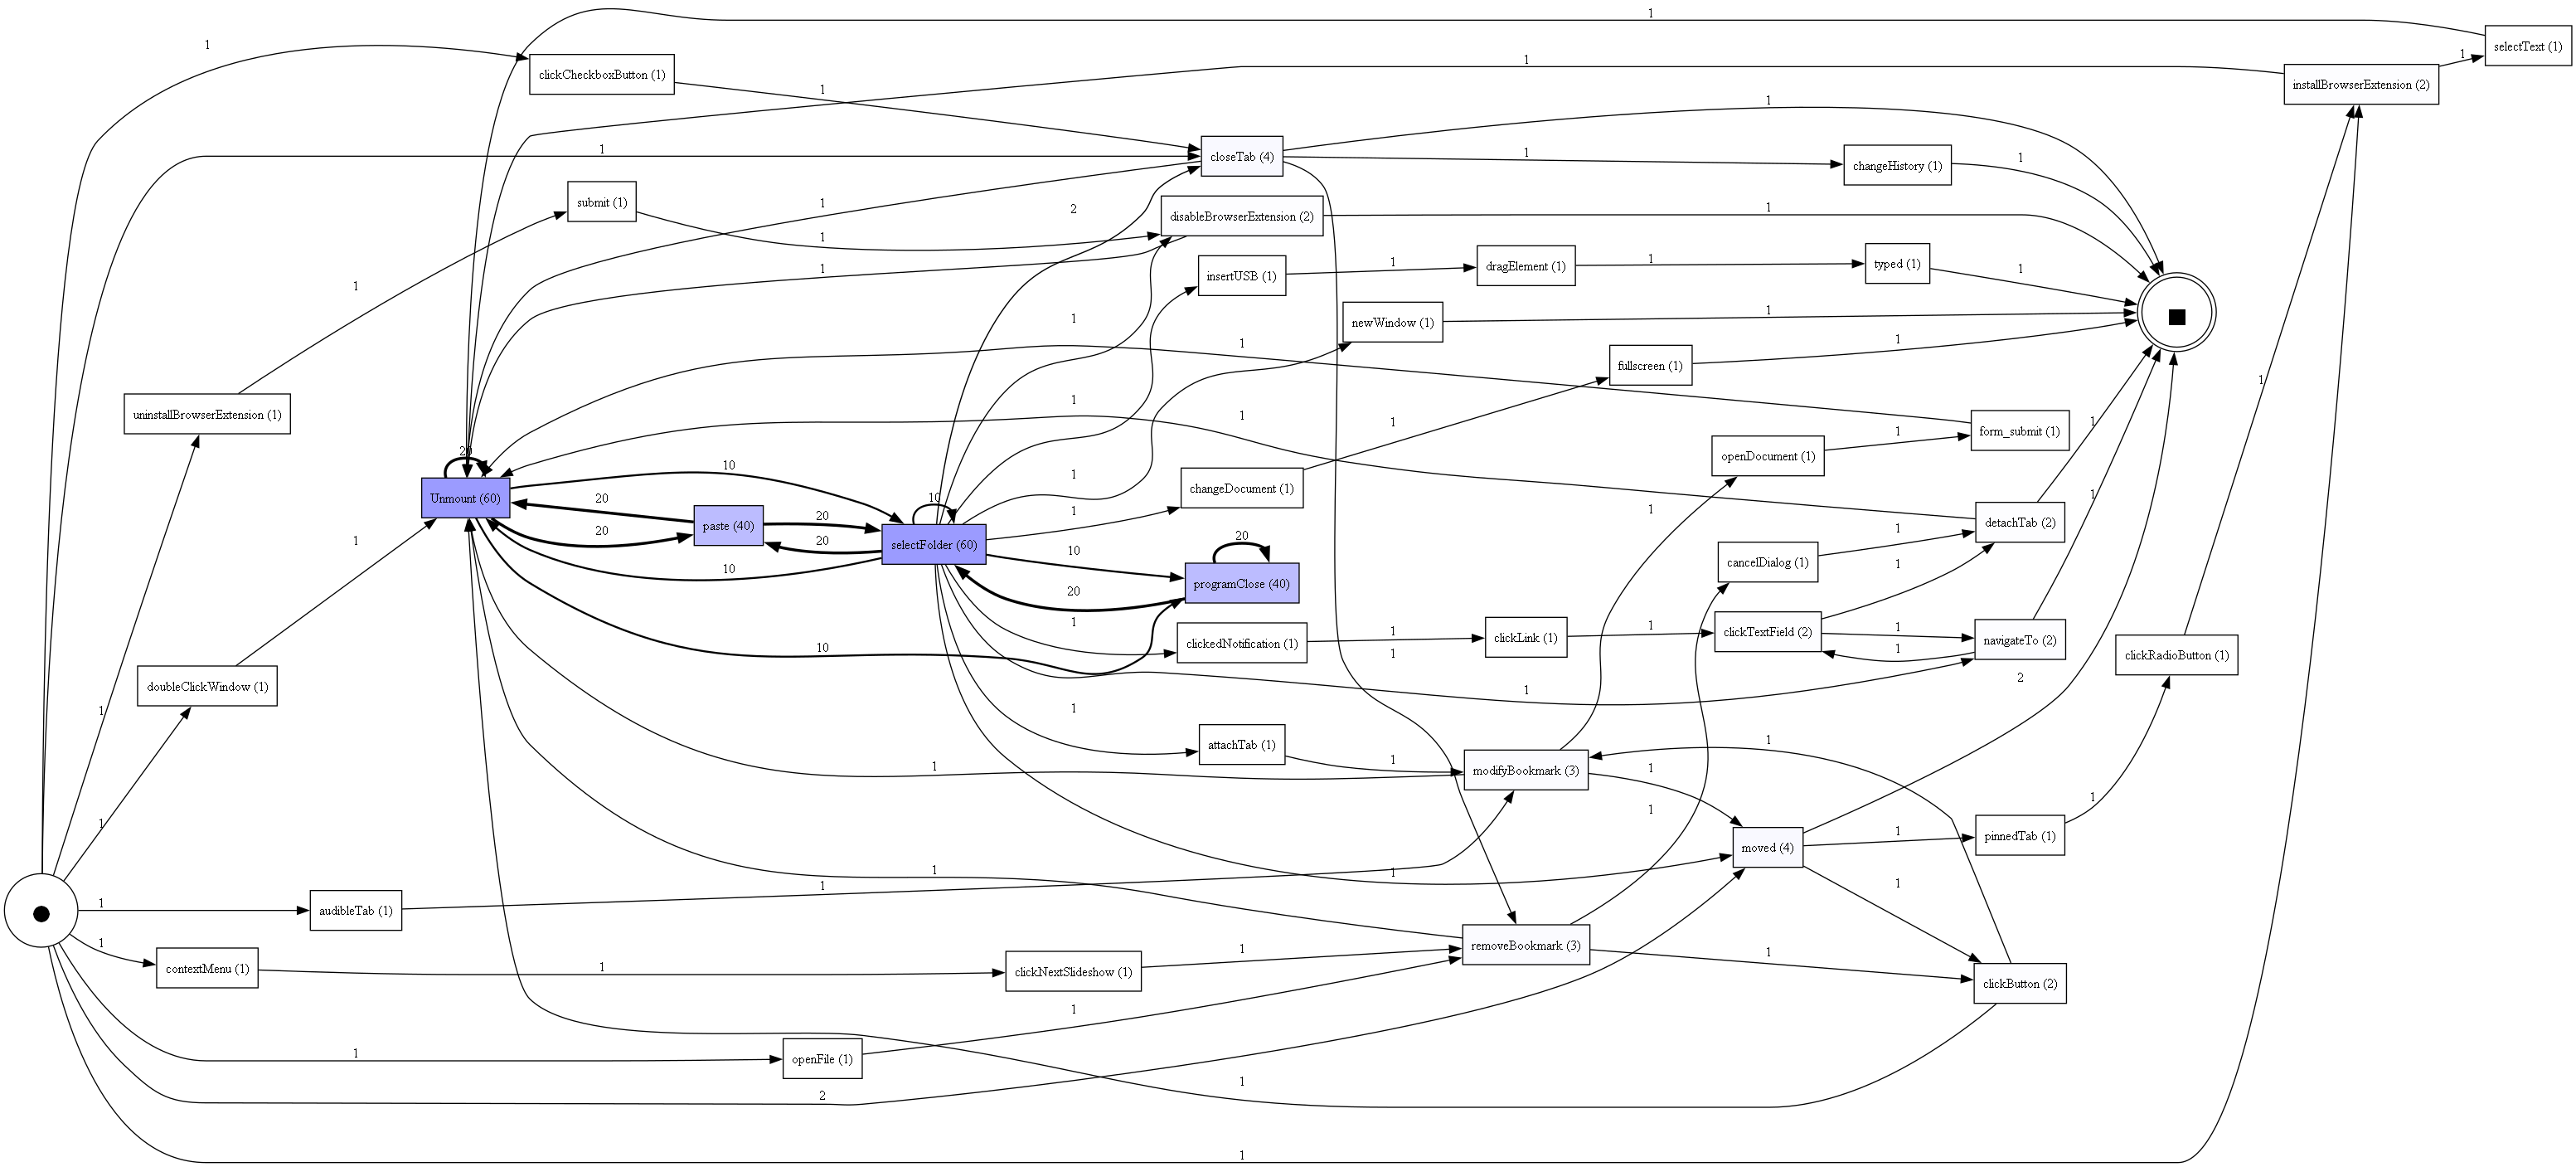

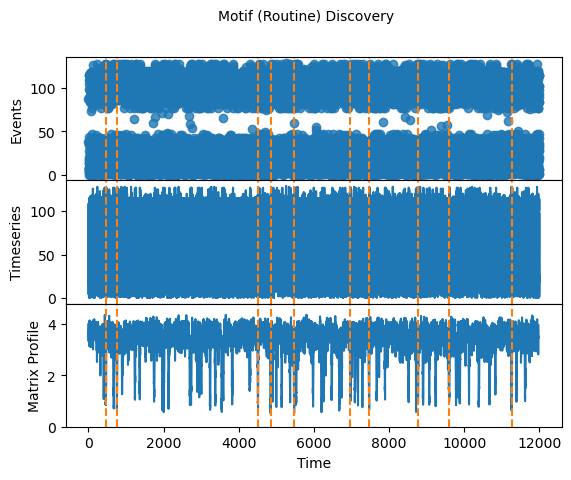

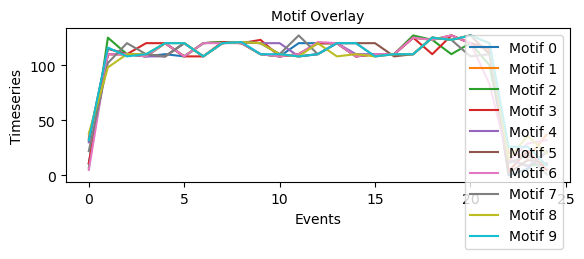

exporting log, completed traces :: 100%|██████████| 10/10 [00:00<00:00, 61.23it/s]


True

<Figure size 640x480 with 0 Axes>

In [5]:
# ---- Do not change from here; Execute Only ----

# ---- PreProcessing ----
file = pd.read_csv(UiLogPath + UiLogFilename, encoding=encoding_method, sep=seperator)
uiLog = util.util.encoding_UiLog(file,orderedColumnsList=ContextColumns,hierarchy_based=True,cooccuranceBased=False)
if WindowSizeCalculation:
    percentil = 100
    quartile, quartile_indices, average_elements = util.util.windowSizeByBreak(file, timeStampColumn, BreakTime, percentil)
    if average_elements is not None:
        size = average_elements
        print(f"Average number of elements between breaks occurrences: {average_elements:.2f}")
    else:
        size = len(file)*0.01
        print(f"Not enough data to calculate the window size. Size will be one percent of log length: {len(file)*0.01}")
    
else:
    size = ManualWindowSize
    print(f"The window size was manually set and is {size}.")

# ---- Generating Result File Name ----
resultFile = "discoveryResults/" + UiLogFilename[:-4] + "_window_" + str(size)

# ---- Time Series Mining ----
tm_matrix, event_series = util.util.discover_motifs(uiLog, size)
# The motifs have to be exclusive, thus, no one activity must be part of a routine already discovered
config.STUMPY_EXCL_ZONE_DENOM = 1  # The exclusion zone is i ± m
top_motifs = stumpy.motifs(T=event_series, P=tm_matrix[:,0], min_neighbors=1, max_matches=NumberOfMotifsToDiscover)
print(f"The motif discovery is complete. The following indexes are the starting points of the discovered motifs: {np.sort(top_motifs[1][0])}")
caseuiLog = util.util.reduceLogToDiscovered(file,top_motifs[1][0],size)

# ---- Process Discovery ----
if awt_data == False:
    pm4pyDf = pm4py.format_dataframe(caseuiLog)
    uiLogDFG, start_activities, end_activities = pm4py.discover_dfg(pm4pyDf)
    pm4py.view_dfg(uiLogDFG, start_activities, end_activities)
    pm4py.save_vis_dfg(uiLogDFG, start_activities, end_activities, resultFile + '.png')

if awt_data == True:
    caseuiLog["concept:name"] = caseuiLog["Title"]
    caseuiLog["time:timestamp"] = caseuiLog["Begin"]
    caseuiLog['case:concept:name'] = caseuiLog['case:concept:name'].astype('int64')
    pm4pyDf = pm4py.format_dataframe(caseuiLog)
    uiLogDFG, start_activities, end_activities = pm4py.discover_dfg(pm4pyDf)
    pm4py.view_dfg(uiLogDFG, start_activities, end_activities)
    pm4py.save_vis_dfg(uiLogDFG, start_activities, end_activities, resultFile + '.png')

# ---- Motif Visualisation ----
starting_row = 0
ending_row = len(uiLog)-1
ids = uiLog.loc[starting_row:ending_row,'tuple:id'].tolist()
rows = [i for i in range(len(uiLog.loc[starting_row:ending_row,'tuple:id']))]

#Plot Event data
fig2, axs2 = plt.subplots(3, sharex=True, gridspec_kw={'hspace': 0})
plt.suptitle('Motif (Routine) Discovery', fontsize='10')

axs2[0].scatter(rows, ids, alpha=0.8)
axs2[0].set_ylabel('Events', fontsize='10')
# Plot Timeseries data
axs2[1].plot(event_series)
axs2[1].set_ylabel('Timeseries', fontsize='10')
# Plot Matrix profiles
axs2[2].set_xlabel('Time', fontsize ='10')
axs2[2].set_ylabel('Matrix Profile', fontsize='10')
axs2[2].set_ylim(top=tm_matrix[:, 0].max()*1.1) #displaying the max value with some uplift for space in Graph
axs2[2].plot(tm_matrix[:, 0])
# Adding Dashed lines
for discovered in top_motifs[1][0]:
    axs2[0].axvline(x=discovered, linestyle="dashed",color='C1')
    axs2[1].axvline(x=discovered, linestyle="dashed",color='C1')
    axs2[2].axvline(x=discovered, linestyle="dashed",color='C1')

# Display Pattern overlay
fig, ax = plt.subplots(figsize=(6.5, 2))
plt.title('Motif Overlay', fontsize='10')
ax.set_xlabel("Events", fontsize='10')
ax.set_ylabel("Timeseries", fontsize='10')
# Plot motif and nearest neighbor window
for i, val in enumerate(top_motifs[1][0]):
    colorPlot = 'C' + str(i)
    ax.plot(event_series[val:val+size], color=colorPlot, label=f"Motif {i}")
    
plt.legend(loc="best",fontsize=10)
plt.show()

# ---- Store reduced UI log as csv, xes, html, DFG.pdf ----

caseuiLog.to_csv(resultFile + ".csv")
pm4py.write_xes(caseuiLog, resultFile + '.xes')
caseuiLog.to_html(resultFile + ".html")
plt.savefig(resultFile + ".pdf")

# ---- Show reduced dataframe with cases in html display ----
webbrowser.open('file://' + os.path.realpath(resultFile + ".html"))